In [21]:
"""Load data, processes it, save it."""

import argparse
import logging
import pickle
import os
from typing import Dict

import numpy as np
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from tqdm import tqdm

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [22]:
data_dir = "/scratch/bdtg/yzhang39/allen/datasets" 
input_dir = f"{data_dir}/raw"
output_dir = f"{data_dir}/processed"

# get the project cache from the warehouse
manifest_path = os.path.join(input_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
# get sessions
sessions = cache.get_session_table()

INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache


In [23]:
for session_id, row in tqdm(sessions.iterrows()):
    # load nwb file through the allen sdk
    session_data = cache.get_session_data(session_id)
    stimulus_presentations = session_data.stimulus_presentations

    logging.info(f"Processing session: {session_id}")

    break

0it [00:00, ?it/s]INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:root:Processing session: 715093703
0it [00:13, ?it/s]


In [24]:
def extract_spikes(session, session_id):

    units = session.units
    spiketimes_dict = session.spike_times

    spikes = []
    unit_index = []
    unit_meta = []

    for i, unit_id in enumerate(spiketimes_dict.keys()):
        metadata = units.loc[unit_id]
        probe_id = metadata["probe_id"]
        probe_channel_id = metadata["probe_channel_number"]
        unit_name = f"{session_id}/{probe_id}/{probe_channel_id}/{unit_id}"

        spiketimes = spiketimes_dict[unit_id]
        spikes.append(spiketimes)
        unit_index.append([i] * len(spiketimes))

        unit_meta.append(
            {
                "count": len(spiketimes),
                "channel_name": probe_channel_id,
                "electrode_row": metadata["probe_horizontal_position"],
                "electrode_col": 0,
                "id": unit_name,
                "area_name": metadata["structure_acronym"],
                "channel_number": probe_channel_id,
                "unit_number": i,
            }
        )

    spikes = np.concatenate(spikes)
    unit_index = np.concatenate(unit_index)

    # convert unit metadata to a Data object
    unit_meta_df = pd.DataFrame(unit_meta)
    units = {
        "unit_index": unit_index, 
        "unit_meta_df": unit_meta_df,
    }

    return spikes, units

In [25]:
def extract_running_speed(session):

    running_speed_dict = {}
    running_speed_df = session.running_speed
    if running_speed_df is not None:
        running_speed_df = running_speed_df[~running_speed_df.isnull().any(axis=1)]
        running_speed_times = (
            running_speed_df["start_time"]
            + (running_speed_df["end_time"] - running_speed_df["start_time"]) / 2
        )
        running_speed_dict.update(
            {
                "timestamps": running_speed_times.values,
                "running_speed": running_speed_df["velocity"]
                .values.astype(np.float32)
                .reshape(-1, 1),  # continues values needs to be 2 dimensional
            }
        )
    return running_speed_dict

In [26]:
def extract_gaze(session):
    gaze_df = session.get_screen_gaze_data(include_filtered_data=True)

    if gaze_df is None:
        return None

    # Filter out rows with nan values
    gaze_df = gaze_df[~gaze_df.isnull().any(axis=1)]

    gaze_dict = {
        "timestamps": gaze_df.index.values,
        "raw_eye_area": gaze_df["raw_eye_area"].values.astype(np.float32),
        "raw_pupil_area": gaze_df["raw_pupil_area"].values.astype(np.float32),
        "raw_screen_coordinates_x_cm": gaze_df[
            "raw_screen_coordinates_x_cm"
        ].values.astype(np.float32),
        "raw_screen_coordinates_y_cm": gaze_df[
            "raw_screen_coordinates_y_cm"
        ].values.astype(np.float32),
        "raw_screen_coordinates_spherical_x_deg": gaze_df[
            "raw_screen_coordinates_spherical_x_deg"
        ].values.astype(np.float32),
        "raw_screen_coordinates_spherical_y_deg": gaze_df[
            "raw_screen_coordinates_spherical_y_deg"
        ].values.astype(np.float32),
        "filtered_eye_area": gaze_df["filtered_eye_area"].values.astype(np.float32),
        "filtered_pupil_area": gaze_df["filtered_pupil_area"].values.astype(np.float32),
        "filtered_screen_coordinates_x_cm": gaze_df[
            "filtered_screen_coordinates_x_cm"
        ].values.astype(np.float32),
        "filtered_screen_coordinates_y_cm": gaze_df[
            "filtered_screen_coordinates_y_cm"
        ].values.astype(np.float32),
        "filtered_screen_coordinates_spherical_x_deg": gaze_df[
            "filtered_screen_coordinates_spherical_x_deg"
        ].values.astype(np.float32),
        "filtered_screen_coordinates_spherical_y_deg": gaze_df[
            "filtered_screen_coordinates_spherical_y_deg"
        ].values.astype(np.float32),
    }

    gaze_dict["pos_2d"] = np.stack(
        [
            gaze_dict["filtered_screen_coordinates_x_cm"],
            gaze_dict["filtered_screen_coordinates_y_cm"],
        ],
        axis=-1,
    )  # (N, 2)

    return gaze_dict

In [27]:
def extract_pupil(session):
    pupil_df = session.get_pupil_data()
    if pupil_df is None:
        return None

    pupil_df = pupil_df[~pupil_df.isnull().any(axis=1)]
    pupil_dict = {
        "timestamps": pupil_df.index.values,
        "corneal_reflection_center_x": pupil_df[
            "corneal_reflection_center_x"
        ].values.astype(np.float32),
        "corneal_reflection_center_y": pupil_df[
            "corneal_reflection_center_y"
        ].values.astype(np.float32),
        "corneal_reflection_height": pupil_df["corneal_reflection_height"].values.astype(
            np.float32
        ),
        "corneal_reflection_width": pupil_df["corneal_reflection_width"].values.astype(
            np.float32
        ),
        "corneal_reflection_phi": pupil_df["corneal_reflection_phi"].values.astype(
            np.float32
        ),
        "pupil_center_x": pupil_df["pupil_center_x"].values.astype(np.float32),
        "pupil_center_y": pupil_df["pupil_center_y"].values.astype(np.float32),
        "pupil_height": pupil_df["pupil_height"].values.astype(np.float32),
        "pupil_width": pupil_df["pupil_width"].values.astype(np.float32),
        "pupil_phi": pupil_df["pupil_phi"].values.astype(np.float32),
        "eye_center_x": pupil_df["eye_center_x"].values.astype(np.float32),
        "eye_center_y": pupil_df["eye_center_y"].values.astype(np.float32),
        "eye_height": pupil_df["eye_height"].values.astype(np.float32),
        "eye_width": pupil_df["eye_width"].values.astype(np.float32),
        "eye_phi": pupil_df["eye_phi"].values.astype(np.float32),
    }

    pupil_dict["size_2d"] = np.stack(
        [pupil_dict.pupil_height, pupil_dict.pupil_width], axis=-1
    )  # (N, 2)

    return pupil_dict

In [28]:
def extract_natural_scenes(stimulus_pres):
    ns_presentations = stimulus_pres[
        np.array(stimulus_pres["stimulus_name"] == "natural_scenes")
        & np.array(stimulus_pres["frame"] != "null")
    ]

    if len(ns_presentations) == 0:
        return None

    start_times = ns_presentations["start_time"].values
    end_times = ns_presentations["stop_time"].values
    image_ids = ns_presentations["frame"].values.astype(np.int64)  # ids span -1 to 117
    image_ids = image_ids + 1  # now they span 0 to 118

    return {
        "start": start_times,
        "end": end_times,
        "image_ids": image_ids,
        "timestamps": start_times / 2.0 + end_times / 2.0,
    }

In [29]:
def extract_gabors(stimulus_pres):
    gabors_presentations = stimulus_pres[
        np.array(stimulus_pres["stimulus_name"] == "gabors")
        & np.array(stimulus_pres["orientation"] != "null")
    ]

    unique_x_pos = np.unique(gabors_presentations.x_position)
    unique_y_pos = np.unique(gabors_presentations.y_position)
    unique_orientations = np.unique(gabors_presentations.orientation)
    unique_x_pos.sort()
    unique_y_pos.sort()
    unique_orientations.sort()

    def calculate_gabors_ori(row):
        gabors_or_map = {"0": 0, "45": 1, "90": 2}
        return gabors_or_map[str(int(row["orientation"]))]

    def calculate_gabors_pos2d(row):
        x_class = np.where(unique_x_pos == row["x_position"])[0][0]
        y_class = np.where(unique_y_pos == row["y_position"])[0][0]
        return np.array([x_class, y_class])

    gabors_start_times = gabors_presentations["start_time"].values
    gabors_end_times = gabors_presentations["stop_time"].values

    gabors_trials = {
        "start": gabors_start_times,
        "end": gabors_end_times,
        "pos_2d": np.vstack(
            gabors_presentations.apply(calculate_gabors_pos2d, axis=1).to_numpy()
        ),  # (N, 2)
        "gabors_orientation": gabors_presentations.apply(
            calculate_gabors_ori, axis=1
        ).to_numpy(),
        "timestamps": gabors_start_times / 2.0 + gabors_end_times / 2.0,
        # other data that might be useful later
        "orientation": gabors_presentations["orientation"].values.astype(
            np.float32
        ),  # (N,)
        "spatial_frequency": gabors_presentations["spatial_frequency"].values.astype(
            np.float32
        ),
        "temporal_frequency": gabors_presentations["temporal_frequency"].values.astype(
            np.float32
        ),
        "x_position": gabors_presentations["x_position"].values.astype(np.float32),
        "y_position": gabors_presentations["y_position"].values.astype(np.float32),
    }
    return gabors_trials

In [30]:
def extract_static_gratings(stimulus_pres):
    static_gratings = stimulus_pres[
        (stimulus_pres["stimulus_name"] == "static_gratings")
        & (stimulus_pres["orientation"] != "null")
    ]

    start_times = static_gratings["start_time"].values
    end_times = static_gratings["stop_time"].values
    orientations = static_gratings["orientation"].values.astype(np.float32)
    orientation_classes = np.round(orientations / 30.0).astype(np.int64)
    output_timestamps = (start_times + end_times) / 2

    return {
        "start": start_times,
        "end": end_times,
        "orientation": orientation_classes,  # (N,)
        "timestamps": output_timestamps,  # (N,)
    }


def extract_drifting_gratings(stimulus_pres):
    drifting_gratings = stimulus_pres[
        (
            (
                stimulus_pres["stimulus_name"] == "drifting_gratings"
            )  # brain_observatory_1.1
            | (
                stimulus_pres["stimulus_name"] == "drifting_gratings_75_repeats"
            )  # functional_connectivity
        )
        & (stimulus_pres["orientation"] != "null")
    ]

    start_times = drifting_gratings["start_time"].values
    end_times = drifting_gratings["stop_time"].values
    orientations = drifting_gratings["orientation"].values.astype(np.float32)
    orientations = np.round(orientations / 45.0).astype(np.int64)
    temp_freq_mapping = {1.0: 0, 2.0: 1, 4.0: 2, 8.0: 3, 15.0: 4}
    temp_freq = np.array(
        [
            temp_freq_mapping[freq]
            for freq in drifting_gratings["temporal_frequency"].values
        ]
    )
    drifting_gratings_dict = {
        "start": start_times,
        "end": end_times,
        "orientation": orientations,  # (N,)
        "temp_freq": temp_freq,  # (N,)
        # NOTE for now, we will center all timestamps assuming a context window of 1s
        "timestamps": np.ones_like(start_times) * 0.5,
    }
    assert np.all(
        drifting_gratings_dict["end"] - drifting_gratings_dict["start"] > 1
    ), "All trials must have a duration greater than 1."
    return drifting_gratings_dict

In [31]:
def get_stim_trial_splits(stim_dict, split_ratios=[0.7, 0.1, 0.2]):
    if stim_dict is None or len(stim_dict["timestamps"]) == 0:
        return {"train": None, "valid": None, "test": None}
    import math

    train_boundary = math.floor(len(stim_dict["timestamps"]) * split_ratios[0])
    valid_boundary = math.floor(len(stim_dict["timestamps"]) * (split_ratios[0] + split_ratios[1]))
    test_boundary = math.floor(len(stim_dict["timestamps"]) * sum(split_ratios))
    
    stim_trials = np.vstack([stim_dict["start"], stim_dict["end"]]).T
    train_trials = stim_trials[:train_boundary - 1] 
    valid_trials = stim_trials[train_boundary: valid_boundary - 1] 
    test_trials = stim_trials[valid_boundary: test_boundary - 1] 
    
    return {"train": train_trials, "valid": valid_trials, "test": test_trials}

In [32]:
def get_behavior_region(running_speed_dict, pupil_dict=None, gaze_dict=None):
    # extract session start and end times
    session_start = min(
        running_speed_dict["timestamps"].min() if running_speed_dict is not None else np.inf,
        pupil_dict["timestamps"].min() if pupil_dict is not None else np.inf,
        gaze_dict["timestamps"].min() if gaze_dict is not None else np.inf,
    )
    session_end = max(
        running_speed_dict["timestamps"].max() if running_speed_dict is not None else 0,
        pupil_dict["timestamps"].max() if pupil_dict is not None else 0,
        gaze_dict["timestamps"].max() if gaze_dict is not None else 0,
    )
    assert (
        session_start < session_end
    ), "Atleast one of running_speed, pupil or gaze data must be present."
    return session_start, session_end

In [33]:
# extract behavior and stimuli data
# using dedicated extract_* helpers into a dictionary
supervision_dict = {
    "running_speed": extract_running_speed(session_data),
    "gaze": extract_gaze(session_data),
    "pupil": extract_pupil(session_data),
    "drifting_gratings": extract_drifting_gratings(stimulus_presentations),
    "static_gratings": extract_static_gratings(stimulus_presentations),
    "gabors": extract_gabors(stimulus_presentations),
    "natural_scenes": extract_natural_scenes(stimulus_presentations),
}


This ecephys session '715093703' has no eye tracking data. (NWB error: "'raw_gaze_mapping' not found in processing of NWBFile 'root'.")
This ecephys session '715093703' has no eye tracking data. (NWB error: "'eye_tracking' not found in processing of NWBFile 'root'.")


In [34]:
# split each stimuli/behavior and combine them
# using dedicated get_*_splits helpers into a dictionary
stimuli_splits_by_key = {
    "drifting_gratings": get_stim_trial_splits(
        supervision_dict.get("drifting_gratings", None)
    ),
    "static_gratings": get_stim_trial_splits(
        supervision_dict.get("static_gratings", None)
    ),
    "gabors": get_stim_trial_splits(supervision_dict.get("gabors", None)),
    "natural_scenes": get_stim_trial_splits(
        supervision_dict.get("natural_scenes", None)
    ),
}


In [35]:
behavior_start, behavior_end = get_behavior_region(
    supervision_dict.get("running_speed", None),
    supervision_dict.get("pupil", None),
    supervision_dict.get("gaze", None),
)

In [36]:
spikes, units = extract_spikes(session_data, session_id)

session_dict = {"data": {}, "splits": {}}

session_dict["data"] = {
    "spikes": spikes,
    "units": units,
    **supervision_dict,
}

session_dict["splits"] = {
    "behavior_start": behavior_start,
    "behavior_end": behavior_end,
    **stimuli_splits_by_key,
}

INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache
INFO:call_caching:Reading data from cache


In [67]:
# with open(f"{output_dir}/{session_id}.pkl", "wb") as f:
#     pickle.dump(session_dict, f)

# logging.info(f"Saved to disk session: {session_id}")

In [37]:
import sys
import uuid
import multiprocessing
from tqdm import tqdm
from iblutil.numerical import bincount2D

def globalize(func):
    def result(*args, **kwargs):
        return func(*args, **kwargs)
    result.__name__ = result.__qualname__ = uuid.uuid4().hex
    setattr(sys.modules[result.__module__], result.__name__, result)
    return result

def bin_spike_count(
    times, 
    units, 
    start, 
    end, 
    binsize=0.01, 
    length=None,
    n_workers=1
):

    num_chunk = len(start)
    if length is None:
        length = int(min(end - start))
    num_bin = int(np.ceil(length / binsize))

    unit_index = np.unique(units)
    unit_count = len(unit_index)

    @globalize
    def count_spike_per_chunk(chunk):
        chunk_id, t_beg, t_end = chunk
        mask = (times >= t_beg) & (times < t_end)
        times_curr = times[mask]
        clust_curr = units[mask]

        if len(times_curr) == 0:
            spike_per_chunk = np.zeros((unit_count, num_bin))
            tbin_ids = np.arange(unit_count)
        else:
            spike_per_chunk, tbin_ids, unit_ids = bincount2D(
                times_curr, clust_curr, xbin=binsize, xlim=[t_beg, t_end]
            )
            _, tbin_ids, _ = np.intersect1d(unit_index, unit_ids, return_indices=True)

        return spike_per_chunk[:,:num_bin], tbin_ids, chunk_id

    spike_count = np.zeros((num_chunk, unit_count, num_bin))

    chunks = list(zip(np.arange(num_chunk), start, end))

    if n_workers == 1:
        for chunk in chunks:
            res = count_spike_per_chunk(chunk)
            spike_count[res[-1], res[1], :] += res[0]
    else:
        with multiprocessing.Pool(processes=n_workers) as pool:
            with tqdm(total=num_chunk) as pbar:
                for res in pool.imap_unordered(count_spike_per_chunk, chunks):
                    pbar.update()
                    spike_count[res[-1], res[1], :] += res[0]
            pbar.close()

    return spike_count

In [38]:
spike_count = bin_spike_count(
    session_dict["data"]["spikes"], 
    session_dict["data"]["units"]["unit_index"], 
    session_dict["data"]["drifting_gratings"]["start"], 
    session_dict["data"]["drifting_gratings"]["end"], 
    binsize=0.02,
    n_workers=1
)

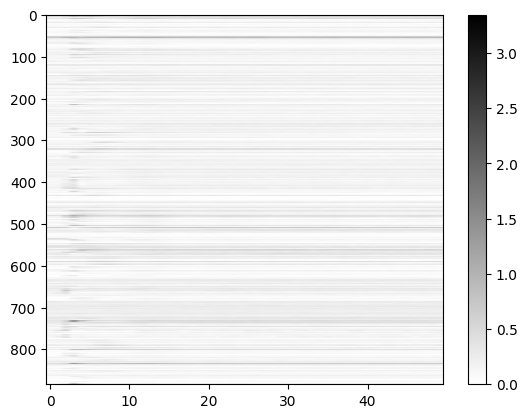

In [39]:
plt.imshow(spike_count.mean(0), aspect="auto", cmap="binary")
plt.colorbar()
plt.show()

In [20]:
from scipy.interpolate import interp1d

def bin_target(
    times, 
    values, 
    start, 
    end, 
    binsize=0.01, 
    length=None,
    n_workers=1, 
):
    
    num_chunk = len(start)
    if length is None:
        length = int(min(end - start))
    num_bin = int(np.ceil(length / binsize))
    
    start_ids = np.searchsorted(times, start, side="right")
    end_ids = np.searchsorted(times, end, side="left")
    times_in = [times[s_id:e_id] for s_id, e_id in zip(start_ids, end_ids)]
    values_in = [values[s_id:e_id] for s_id, e_id in zip(start_ids, end_ids)]

    times_out = [None for _ in range(len(times_in))]
    values_out = [None for _ in range(len(times_in))]
    valid_mask = [None for _ in range(len(times_in))]
    skip_reasons = [None for _ in range(len(times_in))]

    @globalize
    def interpolate_func(target):
        chunk_id, time, val = target

        is_valid, x_interp, y_interp = False, None, None
        
        if np.sum(np.isnan(val)) > 0:
            skip_reason = "nans in target"
            return chunk_id, is_valid, x_interp, y_interp, skip_reason
        if np.isnan(start[chunk_id]) or np.isnan(end[chunk_id]):
            skip_reason = "nans in timestamps"
            return chunk_id, is_valid, x_interp, y_interp, skip_reason
        if np.abs(start[chunk_id] - time[0]) > binsize:
            skip_reason = "target starts too late"
            return chunk_id, is_valid, x_interp, y_interp, skip_reason
        if np.abs(end[chunk_id] - time[-1]) > binsize:
            skip_reason = "target ends too early"
            return chunk_id, is_valid, x_interp, y_interp, skip_reason

        is_valid, skip_reason = True, None
        x_interp = np.linspace(start[chunk_id] + binsize, end[chunk_id], num_bin)
        if len(val.shape) > 1 and val.shape[1] > 1:
            y_interp_list = []
            for n in range(val.shape[1]):
                y_interp_list.append(interp1d(time, val[:,n], kind="linear", fill_value="extrapolate")(x_interp))
            y_interp = np.hstack([y[:,None] for y in y_interp_list])
        else:
            y_interp = interp1d(time, val, kind="linear", fill_value="extrapolate")(x_interp)
        return chunk_id, is_valid, x_interp, y_interp, skip_reason

    if n_workers == 1:
        for chunk in tqdm(list(zip(np.arange(num_chunk), times_in, values_in)), total=num_chunk):
            res = interpolate_func(chunk)
            valid_mask[res[0]] = res[1]
            times_out[res[0]] = res[2]
            values_out[res[0]] = res[3]
            skip_reasons[res[0]] = res[-1]
    else:
        with multiprocessing.Pool(processes=n_workers) as p:
            chunks = list(zip(np.arange(num_chunk), times_in, values_in))
            with tqdm(total=num_chunk) as pbar:
                for res in p.imap_unordered(interpolate_func, chunks):
                    pbar.update()
                    valid_mask[res[0]] = res[1]
                    times_out[res[0]] = res[2]
                    values_out[res[0]] = res[3]
                    skip_reasons[res[0]] = res[-1]
            pbar.close()
            p.close()

    return times_out, values_out, np.array(valid_mask), skip_reasons 

In [ ]:
# find remaining trainable region for behavior

running_speed = bin_target(
    session_dict["data"]["running_speed"]["timestamps"], 
    session_dict["data"]["running_speed"]["running_speed"], 
    # start=, 
    # end=, 
    binsize=0.02,
    n_workers=1
)

In [54]:
import random

def sample_free_behavior_splits(
    start, 
    end, 
    length=1, 
    sample_frac=0.7,
):

    sampled_starts = list(range(int(start), int(end-length+1)))  
    num_samples = int(len(sampled_starts) * sample_frac)
    sampled_starts = random.sample(sampled_starts, min(num_samples, len(sampled_starts)))
    
    all_chunks = np.array([(beg, beg+length) for beg in sampled_starts])

    random.shuffle(all_chunks)

    num_chunk = len(all_chunks)
    train_split = int(num_chunk * 0.7)
    val_split = int(num_chunk * 0.1)
    test_split = num_chunk - train_split - val_split 

    train_chunks = all_chunks[:train_split]
    val_chunks = all_chunks[train_split:train_split+val_split]
    test_chunks = all_chunks[train_split+val_split:]

    return {
        "train": train_chunks,
        "val": val_chunks,
        "test": test_chunks
    }


In [51]:

free_behavior_splits = sample_free_behavior_splits(behavior_start, behavior_end)

(4498, 2)